In [1]:
# Loading Model
from Utils import *
model = CapsNet(input_shape=(20,6000,3), n_class=3, routings=3)
model.load_weights('best_model_CCTCAPS4.h5')
model.summary()

2023-04-06 21:37:53.190502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 21:37:54.257962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9253 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5


KerasTensor(type_spec=TensorSpec(shape=(None, 1880, 40), dtype=tf.float32, name=None), name='layer_normalization_4/batchnorm/add_1:0', description="created by layer 'layer_normalization_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 94, 40), dtype=tf.float32, name=None), name='reshape/Reshape:0', description="created by layer 'reshape'")
Instructions for updating:
Use fn_output_signature instead
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 6000, 3  0           []                               
                                )]                                                                
                                                                                                  
 cct_tokenizer1 (CCTTokenizer1)  (None, 1880, 40)    73080       ['input_1[0][0]'] 

 dropout_4 (Dropout)            (None, 1920, 4)      0           ['primarycap_squash[0][0]']      
                                                                                                  
 digitcaps (CapsuleLayer)       (None, 3, 6)         138240      ['dropout_4[0][0]']              
                                                                                                  
 capsnet (Length)               (None, 3)            0           ['digitcaps[0][0]']              
                                                                                                  
Total params: 260,456
Trainable params: 260,456
Non-trainable params: 0
__________________________________________________________________________________________________


In [4]:
# Set qml and data paths
qmlpath = r'/run/media/omar/My Passport/data2022/events/'
datpath = r'/run/media/omar/My Passport1/WaveformsTexas/waveforms/'


In [5]:
from obspy.core.event import read_events
import numpy as np
import glob
import obspy
import obspy
import numpy as np
from obspy.signal.tf_misfit import cwt
from scipy import signal


fs = 100
dt = 1/100
f_min = 1
f_max = 45


catnameTest = np.load('TEST_HF.npy')
catnameTest = np.array(catnameTest)
outfinSH = []
outfinNH = []

for iu in range(len(catnameTest)):
    print(iu)
    pa = (qmlpath+ catnameTest[iu] + '.qml')
    pa1 = (datpath + catnameTest[iu] + '.mseed')
    cat = read_events(pa)
    st = obspy.read(pa1)
    st = st.resample(100)
    st = st.merge(fill_value=0)
    st = st.filter(type='bandpass', freqmin = 1.0, freqmax = 45, corners=2, zerophase=True)
    st = st.taper(max_percentage=0.001, type='cosine', max_length=2) 

    datfin = []

    for i in cat[0].picks:
        dat = []
        if i.phase_hint=='P':
            st2 = st.copy()
            st2 = st2.select(station=i.waveform_id.station_code)
            if len(st2)==3:
                if len(st2[2].data)>=6000:
                    t = obspy.UTCDateTime(i.time)
                    stall = st2.trim(t-1,t+59-0.01)
                    #print(stall)
                    a0 = stall[0].data
                    a1 = stall[1].data
                    a2 = stall[2].data
                    if (len(a0)==6000) and (len(a1)==6000) and (len(a2)==6000):
                        dat.append(a0)
                        dat.append(a1)
                        dat.append(a2)

                if (len(a0)==6000):
                    dat = np.array(dat) 
                    temp0 = cwt(a0, dt, 10, f_min, f_max, nf=20,  wl='morlet')
                    temp0 = np.clip(np.abs(temp0)[-1::-1], 0, 100)
                    #temp0 = temp0[3:,:]
                    ma = np.max(np.abs(temp0))
                    if ma==0:
                        ma = 1
                    temp0 = temp0 / ma


                    temp1 = cwt(a1, dt, 10, f_min, f_max, nf=20,  wl='morlet')
                    temp1 = np.clip(np.abs(temp1)[-1::-1], 0, 100)
                    #temp1 = temp1[3:,:]
                    ma = np.max(np.abs(temp1))
                    if ma==0:
                        ma = 1
                    temp1 = temp1 / ma

                    temp2 = cwt(a2, dt, 10, f_min, f_max, nf=20,  wl='morlet')
                    temp2 = np.clip(np.abs(temp2)[-1::-1], 0, 100)
                    #temp2 = temp2[3:,:]
                    ma = np.max(np.abs(temp2))
                    if ma==0:
                        ma = 1
                    temp2 = temp2 / ma

                    tmp = np.zeros((20,6000,3))
                    tmp[:,:,0] = np.abs(temp0[:,0:6000])
                    tmp[:,:,1] = np.abs(temp1[:,0:6000])
                    tmp[:,:,2] = np.abs(temp2[:,0:6000])                    
                    datfin.append(tmp) 
    datfin = np.array(datfin)                
    out = model.predict(datfin, batch_size=16)
    out = np.argmax(out,axis=-1)
    outfinSH.append(out)
    outfinNH.append(np.mean(out))

0


2023-04-06 21:38:16.165310: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2023-04-06 21:38:17.300088: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-04-06 21:38:17.356609: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 4s 4s/step
1
1/1 [==============================] - 0s 382ms/step
2
1/1 [==============================] - 0s 342ms/step
3
1/1 [==============================] - 0s 77ms/step
4
1/1 [==============================] - 0s 310ms/step
5
1/1 [==============================] - 0s 244ms/step
6
1/1 [==============================] - 0s 73ms/step
7
1/1 [==============================] - 0s 333ms/step
8
1/1 [==============================] - 0s 168ms/step
9
1/1 [==============================] - 0s 284ms/step
10
1/1 [==============================] - 0s 50ms/step
11
2/2 [==============================] - 0s 156ms/step
12
1/1 [==============================] - 0s 295ms/step
13
1/1 [==============================] - 0s 73ms/step
14
1/1 [==============================] - 0s 70ms/step
15
1/1 [==============================] - 0s 314ms/step
16
1/1 [==============================] - 0s 225ms/step
17
1/1 [==============================] - 0s 55ms/step
18
1/1 [=====

In [6]:
from obspy.core.event import read_events
import numpy as np
import glob
import obspy
import obspy
import numpy as np
from obspy.signal.tf_misfit import cwt
from scipy import signal


fs = 100
dt = 1/100
f_min = 1
f_max = 45


catnameTest = np.load('TEST_SWD.npy')
catnameTest = np.array(catnameTest)
outfinSW = []
outfinNW = []

for iu in range(len(catnameTest)):
    print(iu)
    pa = (qmlpath+ catnameTest[iu] + '.qml')
    pa1 = (datpath + catnameTest[iu] + '.mseed')
    cat = read_events(pa)
    st = obspy.read(pa1)
    st = st.resample(100)
    st = st.merge(fill_value=0)
    st = st.filter(type='bandpass', freqmin = 1.0, freqmax = 45, corners=2, zerophase=True)
    st = st.taper(max_percentage=0.001, type='cosine', max_length=2) 

    datfin = []

    for i in cat[0].picks:
        dat = []
        if i.phase_hint=='P':
            st2 = st.copy()
            st2 = st2.select(station=i.waveform_id.station_code)
            if len(st2)==3:
                if len(st2[2].data)>=6000:
                    t = obspy.UTCDateTime(i.time)
                    stall = st2.trim(t-1,t+59-0.01)
                    #print(stall)
                    a0 = stall[0].data
                    a1 = stall[1].data
                    a2 = stall[2].data
                    if (len(a0)==6000) and (len(a1)==6000) and (len(a2)==6000):
                        dat.append(a0)
                        dat.append(a1)
                        dat.append(a2)

                if (len(a0)==6000):
                    dat = np.array(dat) 
                    temp0 = cwt(a0, dt, 10, f_min, f_max, nf=20,  wl='morlet')
                    temp0 = np.clip(np.abs(temp0)[-1::-1], 0, 100)
                    #temp0 = temp0[3:,:]
                    ma = np.max(np.abs(temp0))
                    if ma==0:
                        ma = 1
                    temp0 = temp0 / ma


                    temp1 = cwt(a1, dt, 10, f_min, f_max, nf=20,  wl='morlet')
                    temp1 = np.clip(np.abs(temp1)[-1::-1], 0, 100)
                    #temp1 = temp1[3:,:]
                    ma = np.max(np.abs(temp1))
                    if ma==0:
                        ma = 1
                    temp1 = temp1 / ma

                    temp2 = cwt(a2, dt, 10, f_min, f_max, nf=20,  wl='morlet')
                    temp2 = np.clip(np.abs(temp2)[-1::-1], 0, 100)
                    #temp2 = temp2[3:,:]
                    ma = np.max(np.abs(temp2))
                    if ma==0:
                        ma = 1
                    temp2 = temp2 / ma

                    tmp = np.zeros((20,6000,3))
                    tmp[:,:,0] = np.abs(temp0[:,0:6000])
                    tmp[:,:,1] = np.abs(temp1[:,0:6000])
                    tmp[:,:,2] = np.abs(temp2[:,0:6000])                    
                    datfin.append(tmp) 
    datfin = np.array(datfin)                
    out = model.predict(datfin, batch_size=16)
    out = np.argmax(out,axis=-1)
    outfinSW.append(out)
    outfinNW.append(np.mean(out))

0
1/1 [==============================] - 0s 65ms/step
1
1/1 [==============================] - 0s 54ms/step
2
1/1 [==============================] - 0s 68ms/step
3
1/1 [==============================] - 0s 78ms/step
4
1/1 [==============================] - 0s 68ms/step
5
2/2 [==============================] - 0s 25ms/step
6
1/1 [==============================] - 0s 45ms/step
7
2/2 [==============================] - 0s 23ms/step
8
1/1 [==============================] - 0s 57ms/step
9
1/1 [==============================] - 0s 65ms/step
10
1/1 [==============================] - 0s 64ms/step
11
2/2 [==============================] - 0s 130ms/step
12
2/2 [==============================] - 0s 166ms/step
13
2/2 [==============================] - 0s 18ms/step
14
1/1 [==============================] - 0s 237ms/step
15
2/2 [==============================] - 0s 35ms/step
16
1/1 [==============================] - 0s 75ms/step
17
1/1 [==============================] - 0s 67ms/step
18
2/2 [=========

In [7]:
from obspy.core.event import read_events
import numpy as np
import glob
import obspy
import obspy
import numpy as np
from obspy.signal.tf_misfit import cwt
from scipy import signal


fs = 100
dt = 1/100
f_min = 1
f_max = 45


catnameTest = np.load('TEST_SWDdp.npy')
catnameTest = np.array(catnameTest)
outfinSWpd = []
outfinNWpd = []

for iu in range(len(catnameTest)):
    print(iu)
    pa = (qmlpath+ catnameTest[iu] + '.qml')
    pa1 = (datpath + catnameTest[iu] + '.mseed')
    cat = read_events(pa)
    st = obspy.read(pa1)
    st = st.resample(100)
    st = st.merge(fill_value=0)
    st = st.filter(type='bandpass', freqmin = 1.0, freqmax = 45, corners=2, zerophase=True)
    st = st.taper(max_percentage=0.001, type='cosine', max_length=2) 

    datfin = []

    for i in cat[0].picks:
        dat = []
        if i.phase_hint=='P':
            st2 = st.copy()
            st2 = st2.select(station=i.waveform_id.station_code)
            if len(st2)==3:
                if len(st2[2].data)>=6000:
                    t = obspy.UTCDateTime(i.time)
                    stall = st2.trim(t-1,t+59-0.01)
                    #print(stall)
                    a0 = stall[0].data
                    a1 = stall[1].data
                    a2 = stall[2].data
                    if (len(a0)==6000) and (len(a1)==6000) and (len(a2)==6000):
                        dat.append(a0)
                        dat.append(a1)
                        dat.append(a2)

                if (len(a0)==6000):
                    dat = np.array(dat) 
                    temp0 = cwt(a0, dt, 10, f_min, f_max, nf=20,  wl='morlet')
                    temp0 = np.clip(np.abs(temp0)[-1::-1], 0, 100)
                    #temp0 = temp0[3:,:]
                    ma = np.max(np.abs(temp0))
                    if ma==0:
                        ma = 1
                    temp0 = temp0 / ma


                    temp1 = cwt(a1, dt, 10, f_min, f_max, nf=20,  wl='morlet')
                    temp1 = np.clip(np.abs(temp1)[-1::-1], 0, 100)
                    #temp1 = temp1[3:,:]
                    ma = np.max(np.abs(temp1))
                    if ma==0:
                        ma = 1
                    temp1 = temp1 / ma

                    temp2 = cwt(a2, dt, 10, f_min, f_max, nf=20,  wl='morlet')
                    temp2 = np.clip(np.abs(temp2)[-1::-1], 0, 100)
                    #temp2 = temp2[3:,:]
                    ma = np.max(np.abs(temp2))
                    if ma==0:
                        ma = 1
                    temp2 = temp2 / ma

                    tmp = np.zeros((20,6000,3))
                    tmp[:,:,0] = np.abs(temp0[:,0:6000])
                    tmp[:,:,1] = np.abs(temp1[:,0:6000])
                    tmp[:,:,2] = np.abs(temp2[:,0:6000])                    
                    datfin.append(tmp) 
    datfin = np.array(datfin)                
    out = model.predict(datfin, batch_size=16)
    out = np.argmax(out,axis=-1)
    outfinSWpd.append(out)
    outfinNWpd.append(np.mean(out))

0
1/1 [==============================] - 0s 65ms/step
1
1/1 [==============================] - 0s 60ms/step
2
1/1 [==============================] - 0s 66ms/step
3
1/1 [==============================] - 0s 59ms/step
4
1/1 [==============================] - 0s 73ms/step
5
1/1 [==============================] - 0s 50ms/step
6
1/1 [==============================] - 0s 75ms/step
7
1/1 [==============================] - 0s 54ms/step
8
1/1 [==============================] - 0s 66ms/step
9
1/1 [==============================] - 0s 47ms/step
10
1/1 [==============================] - 0s 85ms/step
11
1/1 [==============================] - 0s 59ms/step
12
1/1 [==============================] - 0s 39ms/step
13
1/1 [==============================] - 0s 71ms/step
14
1/1 [==============================] - 0s 65ms/step
15
1/1 [==============================] - 0s 60ms/step
16
1/1 [==============================] - 0s 54ms/step
17
2/2 [==============================] - 0s 14ms/step
18
1/1 [============

In [16]:
outfinw = np.round(outfinNW)
outfinsw = np.concatenate( outfinSW, axis=0 )

outfinh = np.round(outfinNH)
outfinsh = np.concatenate( outfinSH, axis=0 )

outfinwpd = np.round(outfinNWpd)
outfinswpd = np.concatenate( outfinSWpd, axis=0 )


<AxesSubplot:>

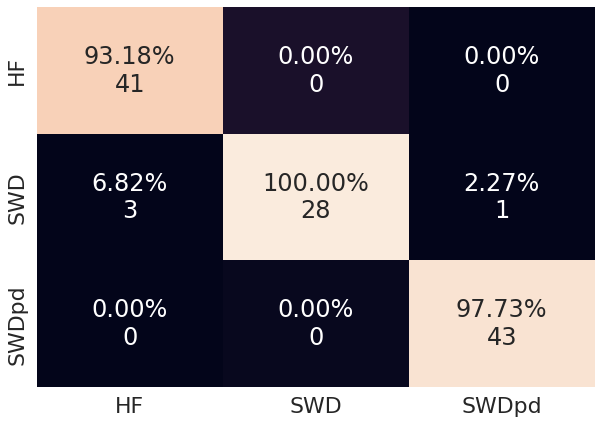

In [17]:
# Network Based
from sklearn.metrics import confusion_matrix
labor = np.concatenate([np.zeros((len(outfinh))),np.ones((len(outfinw))),2*np.ones((len(outfinwpd)))])
labpre = np.concatenate([outfinh,outfinw,outfinwpd])
cf_matrix = confusion_matrix(labpre, labor)
import seaborn as sn
cf = cf_matrix
categories=['HF','SWD','SWDpd']
group_percentages = []
counts = []
for i in range(len(cf)):
    for j in range(len(cf)):
        group_percentages.append(cf[j, i]/np.sum(cf[:, i]))
        counts.append(cf[j, i])

percentages_matrix = np.reshape(group_percentages, (3, 3))
group_percentages = ['{0:.2%}'.format(value) for value in group_percentages]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_percentages, counts)]
labels = np.asarray(labels).reshape(3, 3, order = 'F')

fig = plt.figure(figsize=(10,7))
sn.set(font_scale=2) # for label size
sn.heatmap(percentages_matrix, annot = labels, fmt = '', xticklabels=categories, yticklabels = categories, cbar = False)
#fig.savefig('Conf_Matrix',bbox_inches='tight',transparent=True, dpi =100)


<AxesSubplot:>

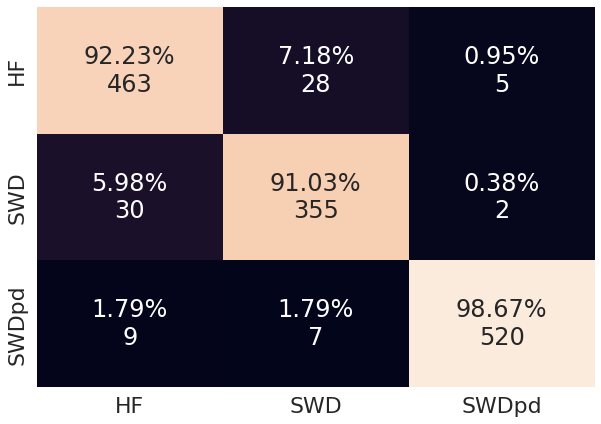

In [18]:
# Singl-station based
import seaborn as sn


labor = np.concatenate([np.zeros((len(outfinsh))),np.ones((len(outfinsw))),2*np.ones((len(outfinswpd)))])
labpre = np.concatenate([outfinsh,outfinsw,outfinswpd])
cf_matrix = confusion_matrix(labpre, labor)

cf = cf_matrix
categories=['HF','SWD','SWDpd']
group_percentages = []
counts = []
for i in range(len(cf)):
    for j in range(len(cf)):
        group_percentages.append(cf[j, i]/np.sum(cf[:, i]))
        counts.append(cf[j, i])

percentages_matrix = np.reshape(group_percentages, (3, 3))
group_percentages = ['{0:.2%}'.format(value) for value in group_percentages]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_percentages, counts)]
labels = np.asarray(labels).reshape(3, 3, order = 'F')

fig = plt.figure(figsize=(10,7))
sn.set(font_scale=2) # for label size
sn.heatmap(percentages_matrix, annot = labels, fmt = '', xticklabels=categories, yticklabels = categories, cbar = False)
#fig.savefig('Conf_Matrix',bbox_inches='tight',transparent=True, dpi =100)
